\begin{split}\begin{aligned}

\mathbf{I}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{\textrm{xi}} + \mathbf{H}_{t-1} \mathbf{W}_{\textrm{hi}} + \mathbf{b}_\textrm{i}),\\

\mathbf{F}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{\textrm{xf}} + \mathbf{H}_{t-1} \mathbf{W}_{\textrm{hf}} + \mathbf{b}_\textrm{f}),\\

\mathbf{O}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{\textrm{xo}} + \mathbf{H}_{t-1} \mathbf{W}_{\textrm{ho}} + \mathbf{b}_\textrm{o}),\\

\tilde{\mathbf{C}}_t &= \textrm{tanh}(\mathbf{X}_t \mathbf{W}_{\textrm{xc}} + \mathbf{H}_{t-1} \mathbf{W}_{\textrm{hc}} + \mathbf{b}_\textrm{c}),\\

\mathbf{H}_t &= \mathbf{O}_t \odot \tanh(\mathbf{C}_t).

\end{aligned}\end{split}

![](svg/lstm-3.svg)

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
class LSTMScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()

        init_weight = lambda *shape: nn.Parameter(torch.randn(*shape) * sigma)
        triple = lambda: (init_weight(num_inputs, num_hiddens),
                          init_weight(num_hiddens, num_hiddens),
                          nn.Parameter(torch.zeros(num_hiddens)))

        self.W_xi, self.W_hi, self.b_i = triple()  # Input gate
        self.W_xf, self.W_hf, self.b_f = triple()  # Forget gate
        self.W_xo, self.W_ho, self.b_o = triple()  # Output gate
        self.W_xc, self.W_hc, self.b_c = triple()  # Input node

    def forward(self, inputs, H_C=None):
        if H_C is None:
            # Initial state with shape: (batch_size, num_hiddens)
            H = torch.zeros((inputs.shape[1], self.num_hiddens),
                            device=inputs.device)
            C = torch.zeros((inputs.shape[1], self.num_hiddens),
                            device=inputs.device)
        else:
            H, C = H_C

        outputs = []
        for X in inputs:
            I = torch.sigmoid(torch.matmul(X, self.W_xi) +
                              torch.matmul(H, self.W_hi) + self.b_i)
            F = torch.sigmoid(torch.matmul(X, self.W_xf) +
                              torch.matmul(H, self.W_hf) + self.b_f)
            O = torch.sigmoid(torch.matmul(X, self.W_xo) +
                              torch.matmul(H, self.W_ho) + self.b_o)
            C_tilde = torch.tanh(torch.matmul(X, self.W_xc) +
                                 torch.matmul(H, self.W_hc) + self.b_c)
            C = F * C + I * C_tilde
            H = O * torch.tanh(C)
            outputs.append(H)
        return outputs, (H, C)

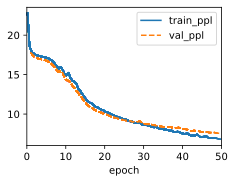

In [3]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
lstm = LSTMScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLMScratch(lstm, vocab_size=len(data.vocab), lr=4)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

## Concise Implementation

In [4]:
class LSTM(d2l.RNN):
    def __init__(self, num_inputs, num_hiddens):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.LSTM(num_inputs, num_hiddens)

    def forward(self, inputs, H_C=None):
        return self.rnn(inputs, H_C)

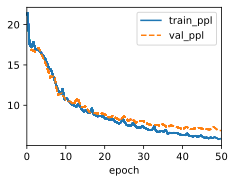

In [5]:
lstm = LSTM(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLM(lstm, vocab_size=len(data.vocab), lr=4)
trainer.fit(model, data)